In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.decomposition import PCA

In [3]:
# home_df = pd.read_csv('../Pt3_Data_processing/home_structured_ewm16.csv')
# away_df = pd.read_csv('../Pt3_Data_processing/away_structured_ewm16.csv')

df = pd.read_csv('../Pt3_Data_processing/home_structured_ewm18_nonadj.csv')
df.sort_values(by='h_pg_date', inplace=True)

# Turning IDS into categorical variables
for col in df:
    if 'id' in col:
        df[col]=df[col].astype('category')
    
# Turning age into integers        
for col in [col for col in df if 'age' in col]:
    df[col] = df[col].apply(lambda x: int(x.replace(' days 00:00:00.000000000','')))
    
df.drop_duplicates(inplace=True)
# df.drop(columns='Unnamed: 0', inplace=True)
df.columns

Index(['h_pg_date', 'h_pg_season_id', 'h_pg_location', 'h_pg_type',
       'h_pg_outcome', 'h_pg_difference', 'h_pg_game_id', 'h_pg_team_id',
       'h_pg_team_abb', 'h_pg_team_city',
       ...
       'a_s3_ewm_ast_pct', 'a_s3_ewm_ast_tov', 'a_s3_ewm_ast_ratio',
       'a_s3_ewm_oreb_pct', 'a_s3_ewm_dreb_pct', 'a_s3_ewm_reb_pct',
       'a_s3_ewm_tm_tov_pct', 'a_s3_ewm_usg_pct', 'a_s3_ewm_game_score',
       'a_s3_ewm_plus_minus'],
      dtype='object', length=580)

In [4]:
[col for col in df if any(a in col for a in['outcome', 'difference'])]

['h_pg_outcome', 'h_pg_difference', 'a_pg_outcome', 'a_pg_difference']

In [5]:
name_id_remove = [col for col in df if any(c in col for c in ['_player_id','_name', '_team'])] + \
['a_pg_outcome', 'a_pg_difference']

modelling_columns = ['h_pg_outcome', 'h_pg_difference', 'h_pg_type', 'h_pg_location'] + \
[col for col in df.loc[:,'h_pg_age_days':] if \
                     col not in name_id_remove]

X = df[modelling_columns].copy()
# X.fillna(value=0, inplace=True)

print('COVID\n',X['h_pg_outcome'][X['a_pg_date']>'2020-03-30'].value_counts(normalize=True))
print('\n2018-\n',X['h_pg_outcome'][X['a_pg_date']>'2018-08-30'].value_counts(normalize=True))
print('\n-2018\n',X['h_pg_outcome'][X['a_pg_date']<'2018-08-30'].value_counts(normalize=True))
print('\n2019-\n',X['h_pg_outcome'][X['a_pg_date']>'2019-08-30'].value_counts(normalize=True))
print('\n-2019\n',X['h_pg_outcome'][X['a_pg_date']<'2019-08-30'].value_counts(normalize=True))

X[X['a_pg_date']>'2017-08-30'].shape[0], X[X['a_pg_date']<'2017-08-30'].shape[0]

# REMOVING FIRST YEAR OF GAMES AND POST-COVID 
# (GAMES NOT PLAYED ON HOME COURTS, DATA CONSTRUCTION WOULD CAUSE ISSUES)
X.drop(X[X['a_pg_date']<'2001-08-30'].index, inplace=True)
X.drop(X[X['a_pg_date']>'2020-03-30'].index, inplace=True)

print('\nBASELINE FOR TOTAL DATASET :\n',X['h_pg_outcome'].value_counts(normalize=True))

print('\nDF SHAPE :\n',X.shape)

COVID
 1    0.533333
0    0.466667
Name: h_pg_outcome, dtype: float64

2018-
 1    0.571667
0    0.428333
Name: h_pg_outcome, dtype: float64

-2018
 1    0.600805
0    0.399195
Name: h_pg_outcome, dtype: float64

2019-
 1    0.549639
0    0.450361
Name: h_pg_outcome, dtype: float64

-2019
 1    0.600271
0    0.399729
Name: h_pg_outcome, dtype: float64

BASELINE FOR TOTAL DATASET :
 1    0.597252
0    0.402748
Name: h_pg_outcome, dtype: float64

DF SHAPE :
 (23002, 537)


### Feature engineering
- Shot percentages
- Game-score

In [8]:
# import pickle
# file = open("../Pt3_Data_processing/br_glossary.pickle",'rb')
# br_glossary = pickle.load(file)
# br_glossary['GmSc']

In [6]:
for i in range(16):
#     PREFIX FOR NEW COLUMN NAMES
    prefix = [col for col in X if 'fgm' in col][i][:4]
#     FG%
    X[f'{prefix}_fgpct'] = X[[col for col in X if 'fgm' in col][i]] / \
    X[[col for col in X if 'fga' in col][i]]
#     FG3%
    X[f'{prefix[:-4]}_fg3pct'] = X[[col for col in X if 'fg3m' in col][i]] / \
    X[[col for col in X if 'fg3a' in col][i]]
#     FT%
    X[f'{prefix[:-4]}_ftpct'] = X[[col for col in X if 'ftm' in col][i]] / \
    X[[col for col in X if 'fta' in col][i]]
#     JOHN HOLLINGER GAMESCORE
    X[f'{prefix}_gs'] = X[f'{prefix}_ewm_pts'] + .4*X[[col for col in X if 'fgm' in col][i]] - \
    .7*X[[col for col in X if 'fga' in col][i]] - .4*(X[[col for col in X if 'fta' in col][i]] - \
                                                     X[[col for col in X if 'ftm' in col][i]]) + \
    .7*X[[col for col in X if 'oreb' in col][i]] + .3*X[[col for col in X if 'dreb' in col][i]] + \
    X[[col for col in X if '_stl' in col][i]] + .7*X[[col for col in X if 'ewm_ast' in col][i]] + \
    .7*X[[col for col in X if 'ewm_blk' in col][i]] - .4*X[[col for col in X if 'ewm_pf' in col][i]] - \
    X[[col for col in X if 'ewm_to' in col][i]]
    

In [7]:
X.drop(columns=['a_pg_season_id', 'a_pg_location', 'a_pg_type','a_pg_game_id'], inplace=True)

X.fillna(0, inplace=True)


X_train = X[X['a_pg_date']<'2017-08-30'].copy()
X_test = X[X['a_pg_date']>'2017-08-30'].copy()

X_train.drop(columns='a_pg_date', inplace=True)
X_test.drop(columns='a_pg_date', inplace=True)


yC_train = X_train.pop('h_pg_outcome')
yC_test = X_test.pop('h_pg_outcome')

yR_train = X_train.pop('h_pg_difference')
yR_test = X_test.pop('h_pg_difference')

X_train.columns

Index(['h_pg_type', 'h_pg_location', 'h_pg_age_days', 'h_pg_height',
       'h_pg_ewm_seconds', 'h_pg_ewm_fgm', 'h_pg_ewm_fga', 'h_pg_ewm_fg3m',
       'h_pg_ewm_fg3a', 'h_pg_ewm_ftm',
       ...
       'a_pf_fgpct', 'a_pf_gs', 'a_c__fgpct', 'a_c__gs', 'a_s1_fgpct',
       'a_s1_gs', 'a_s2_fgpct', 'a_s2_gs', 'a_s3_fgpct', 'a_s3_gs'],
      dtype='object', length=564)

In [12]:
del df

No handles with labels found to put in legend.


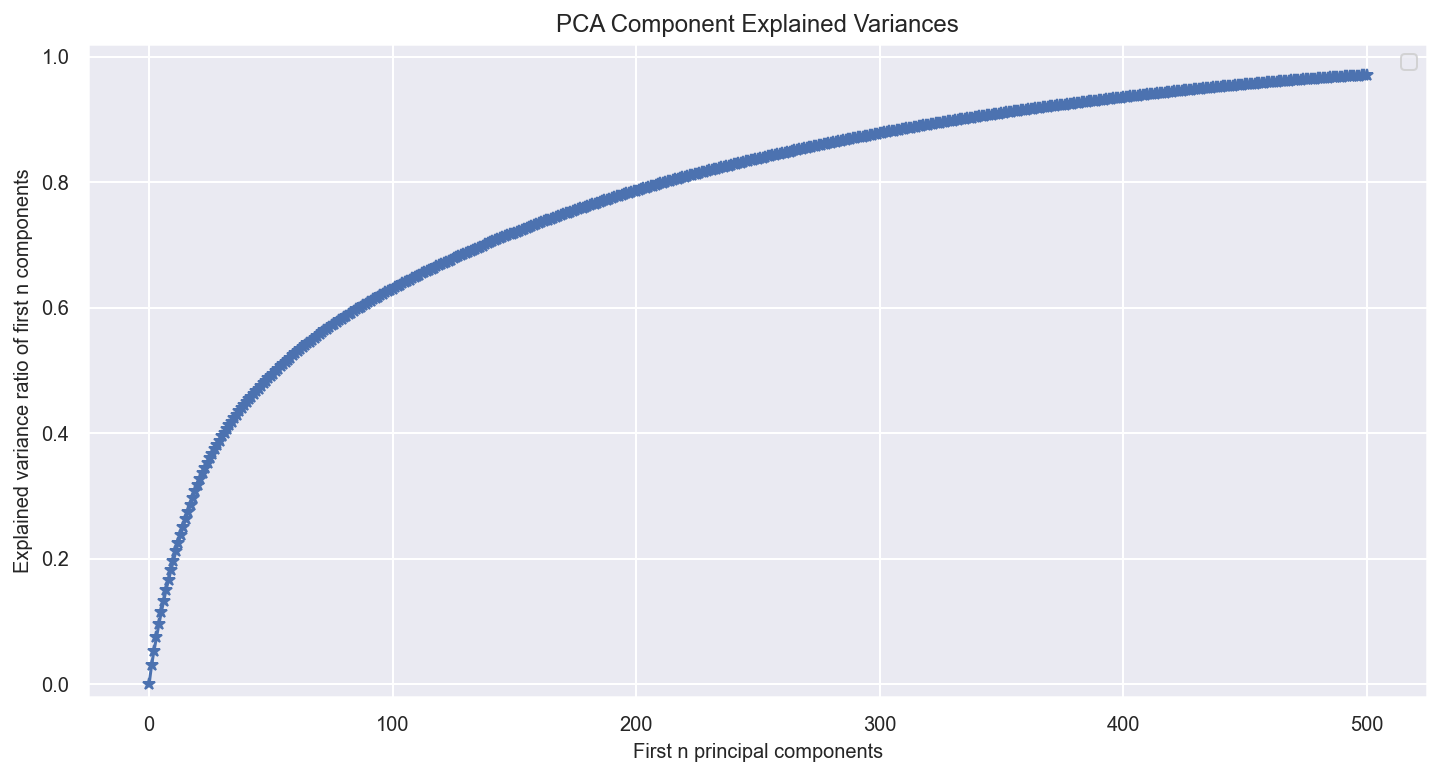

In [13]:
pca = PCA(n_components=500)
scaler = StandardScaler()

pca.fit(scaler.fit_transform(X_train))

# Scree plot
from scikitplot.decomposition import plot_pca_component_variance

plot_pca_component_variance(pca, target_explained_variance=0.999, figsize=(12, 6))
plt.show()

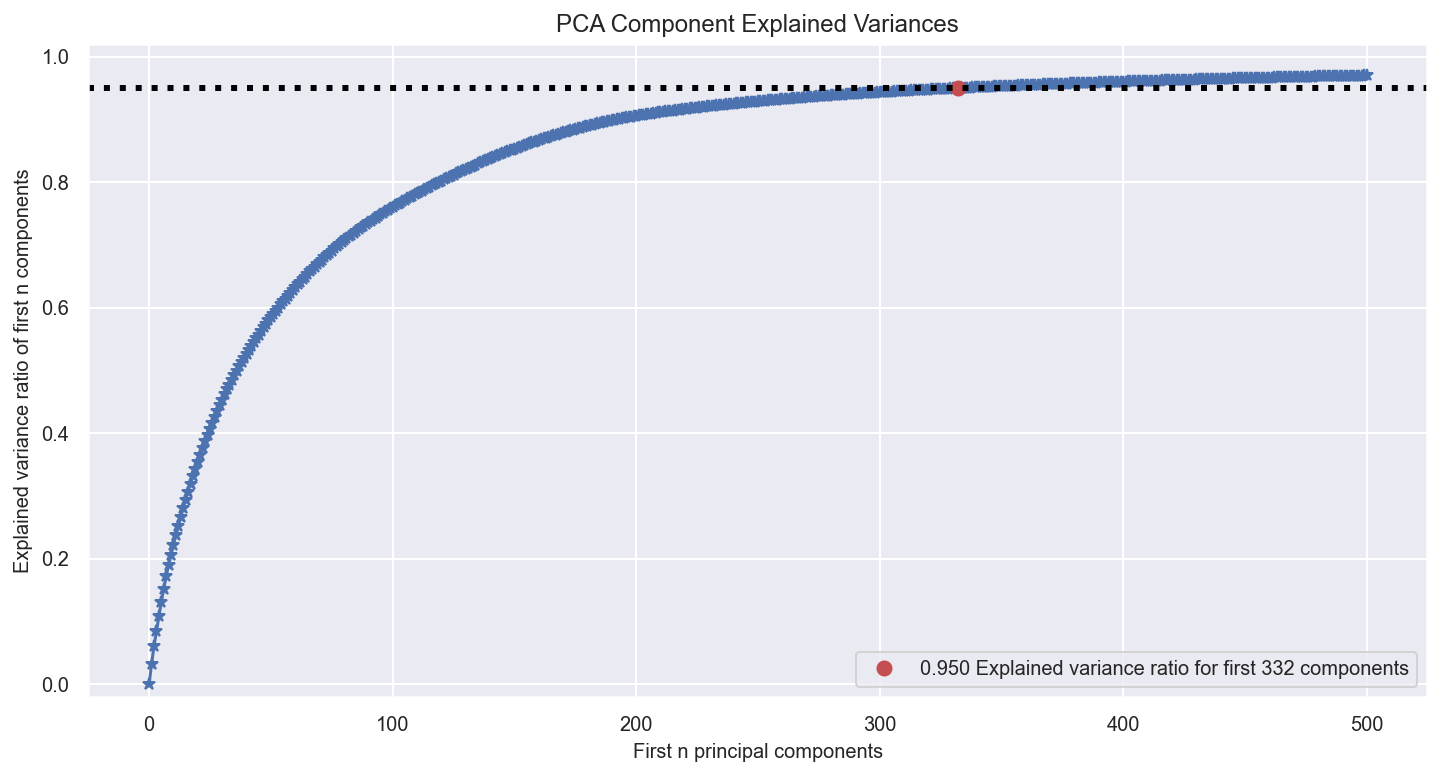

In [13]:
plot_pca_component_variance(pca, target_explained_variance=0.95, figsize=(12, 6))
plt.show()

In [14]:
del pca

In [15]:
del scaler

In [8]:
pipe = Pipeline([('scaler', StandardScaler()),
                #('pca', PCA(n_components=500)),
                ('model', LogisticRegression(max_iter=1000000))])
pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000000))])

In [9]:
def log_fit_display(X_train=X_train, X_test=X_test, y_train=yC_train, y_test=yC_test,
                    pipe=pipe, c_min=0.001,c_max=1, c_space=20,
                    l1_min=.0001,l1_max=.9999, l1_space=20):

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    lr_model = pipe

    solvers = ['saga']
    penalty = ['elasticnet']
    c_values = np.linspace(c_min,c_max,c_space)
    l1_ratios = np.linspace(l1_min,l1_max,l1_space)
#     multi_class = ['ovr', 'multinomial']
#     fit_intercept = [True,False]


    gs_params = {'model__penalty': penalty,
                 'model__solver': solvers,
                 'model__l1_ratio': l1_ratios,
                 'model__C': c_values
#                  ,'logisticregression__multi_class': multi_class
#                  ,'logisticregression__fit_intercept': fit_intercept
                }

    lr_grid = GridSearchCV(lr_model, gs_params, n_jobs=2, verbose=3, cv=kf)

    lr_grid.fit(X_train, y_train)
    
    print('=' * 40)

    print('Train score : ', lr_grid.score(X_train, y_train))
    print('Test score  : ', lr_grid.score(X_test, y_test))
    print('Mean score. : ', lr_grid.best_score_)
    print('Best params :\n', lr_grid.best_params_,'\n----------')

    print('Train : \n', metrics.classification_report(
        y_train, lr_grid.predict(X_train)),'\n')
    print('Test. : \n', metrics.classification_report(
        y_test, lr_grid.predict(X_test)),'\n')
    
    print('\nCONFUSION TRAIN SET')
    plot_confusion_matrix(lr_grid.best_estimator_,
                          X_train, y_train, cmap=plt.cm.binary,)

    print('\nCONFUSION TEST SET')
    plot_confusion_matrix(lr_grid.best_estimator_,
                          X_test, y_test, cmap=plt.cm.binary)

    plt.show()
    return lr_grid

In [10]:
[col for col in X_train if any(a in col for a in['outcome', 'difference'])]

[]

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 11.4min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 84.7min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 257.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 533.0min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 908.6min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 1341.7min
[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed: 1837.6min finished


Train score :  0.6809787626962143
Test score  :  0.6630558722919042
Mean score. :  0.6725653957922405
Best params :
 {'model__C': 0.001, 'model__l1_ratio': 0.05272105263157895, 'model__penalty': 'elasticnet', 'model__solver': 'saga'} 
----------
Train : 
               precision    recall  f1-score   support

           0       0.64      0.45      0.53      7787
           1       0.70      0.83      0.76     11707

    accuracy                           0.68     19494
   macro avg       0.67      0.64      0.64     19494
weighted avg       0.67      0.68      0.67     19494
 

Test. : 
               precision    recall  f1-score   support

           0       0.63      0.49      0.55      1477
           1       0.68      0.79      0.73      2031

    accuracy                           0.66      3508
   macro avg       0.65      0.64      0.64      3508
weighted avg       0.66      0.66      0.65      3508
 


CONFUSION TRAIN SET

CONFUSION TEST SET


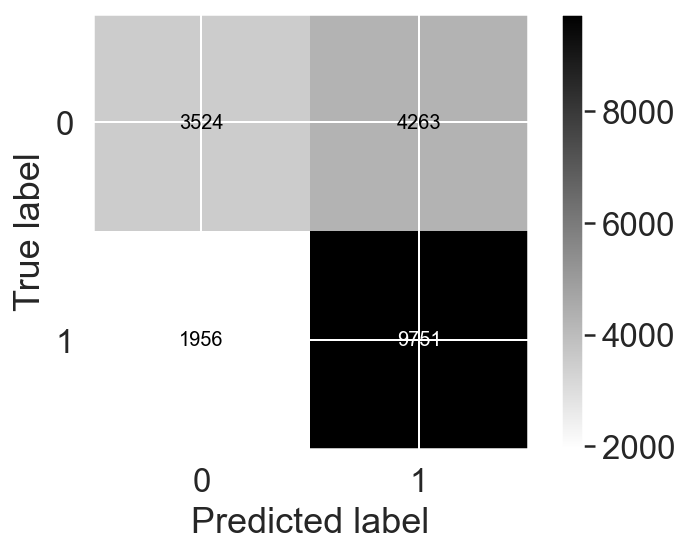

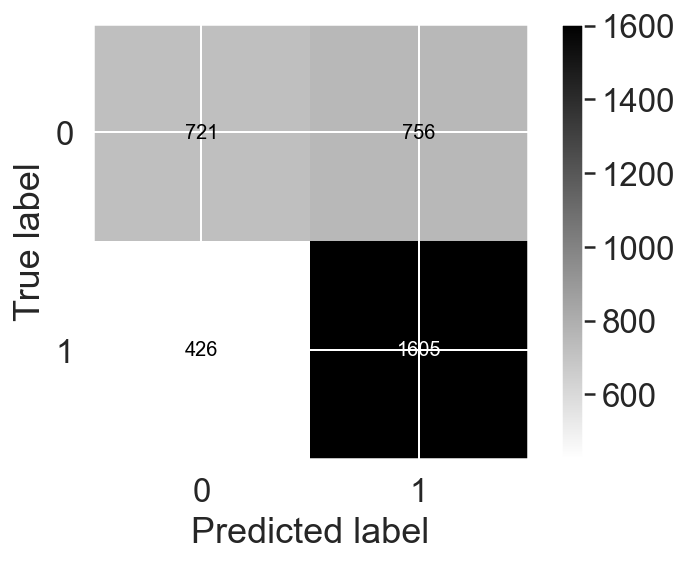

In [11]:
lr_grid = log_fit_display()
results = pd.DataFrame(lr_grid.cv_results_)

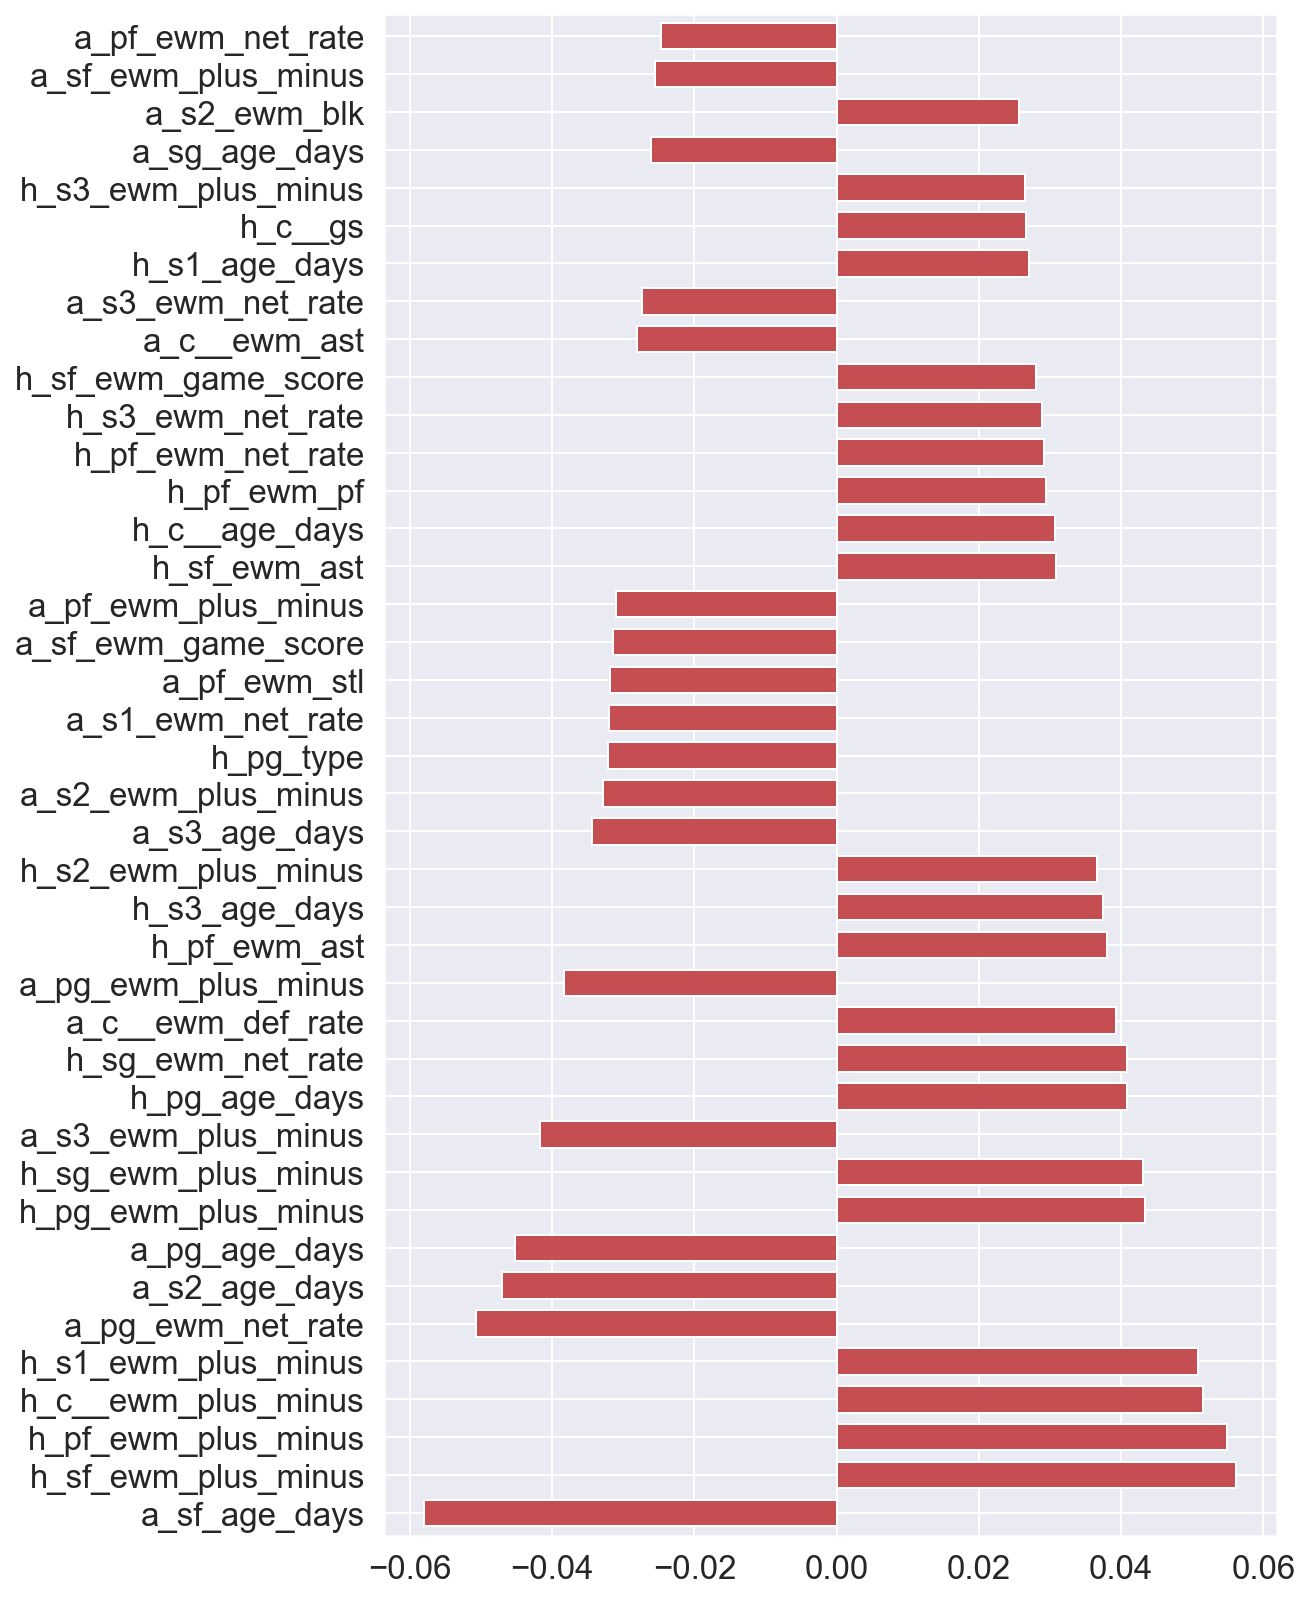

In [12]:
best_coeffs = pd.DataFrame(lr_grid.best_estimator_.steps[1][1].coef_,
                           columns=X_train.columns).T

best_coeffs.columns = ['coefficients']

best_coeffs['abs_coef'] = best_coeffs.coefficients.apply(abs)

best_coeffs.sort_values(by='abs_coef',
                        ascending=False).head(40)['coefficients'].plot(kind='barh',
                                                                      figsize=(8,14),
                                                                      color='r',
                                                                      width=.7);

In [126]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__l1_ratio,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.371639,0.052110,0.060558,0.011267,0.001,0.0001,elasticnet,saga,"{'model__C': 0.001, 'model__l1_ratio': 0.0001,...",0.671454,0.670428,0.669659,0.654014,0.665726,0.666256,0.006421,5
1,1.206397,0.043737,0.050871,0.002224,0.001,0.0345759,elasticnet,saga,"{'model__C': 0.001, 'model__l1_ratio': 0.03457...",0.672480,0.667864,0.668377,0.653757,0.664187,0.665333,0.006357,772
2,1.188391,0.022990,0.051155,0.002089,0.001,0.0690517,elasticnet,saga,"{'model__C': 0.001, 'model__l1_ratio': 0.06905...",0.672737,0.667351,0.667864,0.654783,0.663417,0.665230,0.006003,838
3,1.174661,0.018567,0.050299,0.002195,0.001,0.103528,elasticnet,saga,"{'model__C': 0.001, 'model__l1_ratio': 0.10352...",0.673250,0.668377,0.669146,0.652731,0.662904,0.665282,0.007087,810
4,1.176773,0.029854,0.052145,0.001512,0.001,0.138003,elasticnet,saga,"{'model__C': 0.001, 'model__l1_ratio': 0.13800...",0.674275,0.667094,0.669402,0.652219,0.664443,0.665487,0.007380,602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,1.088588,0.028192,0.048205,0.001559,1,0.861997,elasticnet,saga,"{'model__C': 1.0, 'model__l1_ratio': 0.8619965...",0.670172,0.669915,0.668120,0.653501,0.665983,0.665538,0.006203,490
896,1.058918,0.010877,0.045698,0.001311,1,0.896472,elasticnet,saga,"{'model__C': 1.0, 'model__l1_ratio': 0.8964724...",0.670685,0.670685,0.668120,0.653244,0.667009,0.665949,0.006513,25
897,1.084620,0.014122,0.047054,0.002637,1,0.930948,elasticnet,saga,"{'model__C': 1.0, 'model__l1_ratio': 0.9309482...",0.669915,0.670172,0.668889,0.651962,0.665983,0.665384,0.006874,713
898,1.061415,0.024068,0.046646,0.001223,1,0.965424,elasticnet,saga,"{'model__C': 1.0, 'model__l1_ratio': 0.9654241...",0.670428,0.669659,0.668120,0.652988,0.667265,0.665692,0.006449,208


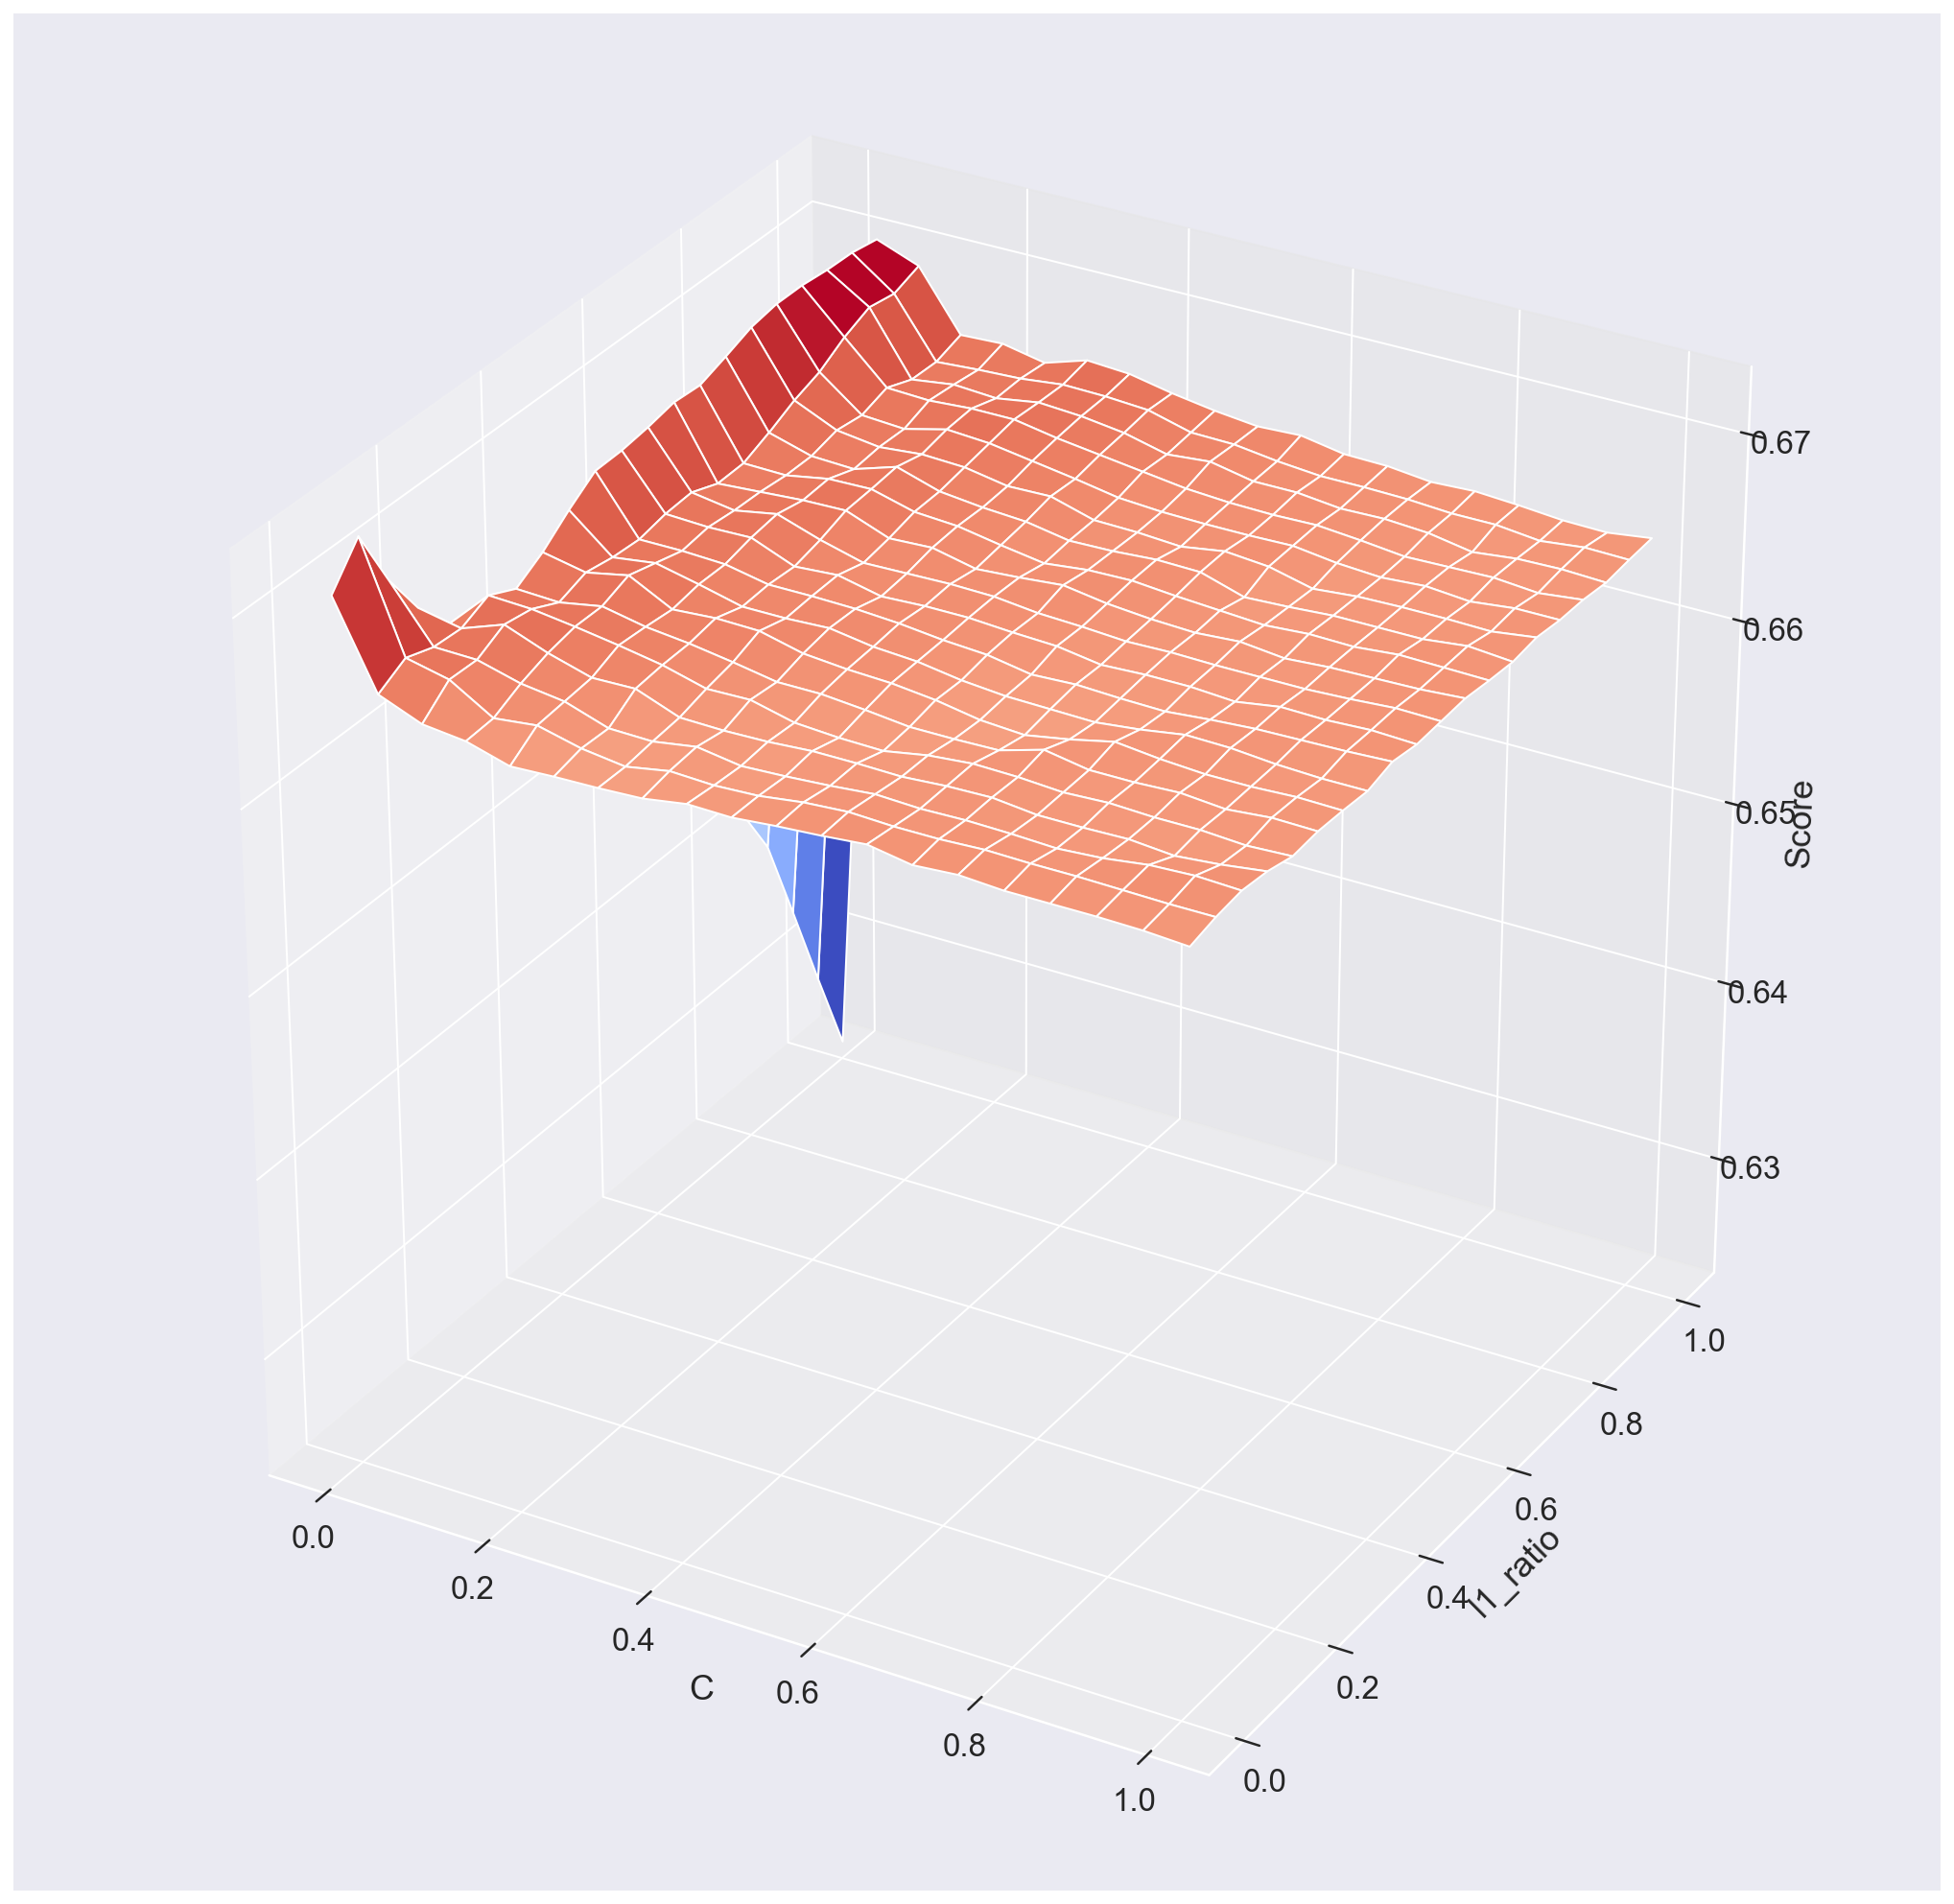

In [13]:
from mpl_toolkits import mplot3d

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, PolyCollection

x_y_z_cols = ['param_model__C',
              'param_model__l1_ratio',
              'mean_test_score']

C_values = results[x_y_z_cols[0]]
l1_values = results[x_y_z_cols[1]]
cv_scores = results[x_y_z_cols[2]]


x_plane = np.reshape(np.array(C_values), (20, 20))
y_plane = np.reshape(np.array(l1_values), (20, 20))
z_plane = np.reshape(np.array(cv_scores), (20, 20))
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_plane, y_plane, z_plane, cmap='coolwarm')

# ax.axis('equal')
ax.set_xlabel(x_y_z_cols[0].replace('param_model__',''))
ax.set_ylabel(x_y_z_cols[1].replace('param_model__',''))
ax.set_zlabel('Score')

plt.show()

In [22]:
from scikitplot.decomposition import plot_pca_component_variance

plot_pca_component_variance(pca, target_explained_variance=0.95, figsize=(12, 6))
plt.show()

NameError: name 'pca' is not defined

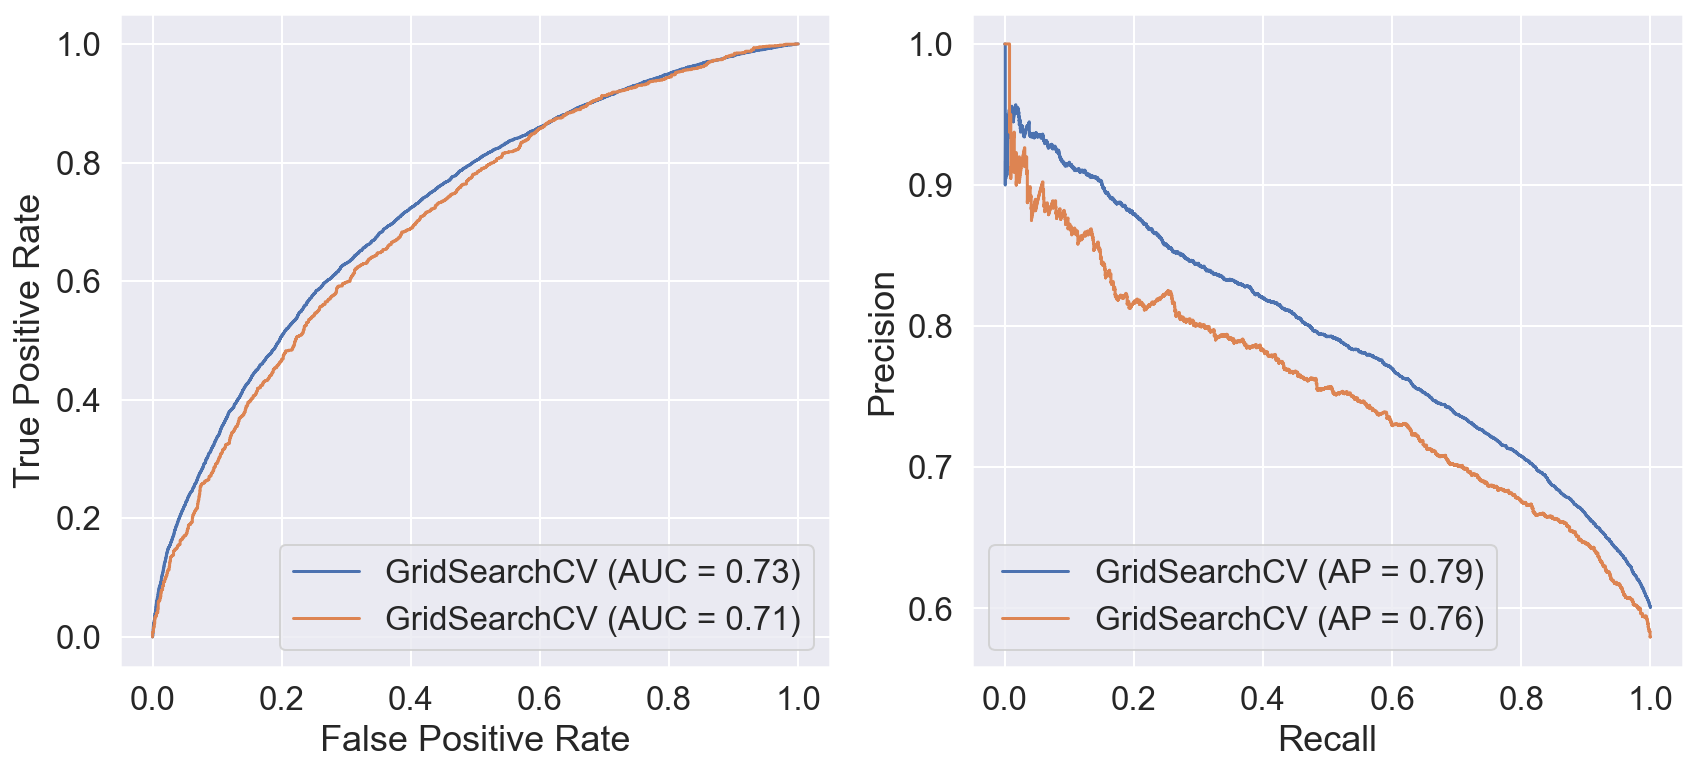

In [14]:
fig, ax = plt.subplots(figsize=(14,6), ncols=2)
metrics.plot_roc_curve(lr_grid, X_train, yC_train, ax=ax[0])
metrics.plot_precision_recall_curve(lr_grid, X_train, yC_train, ax=ax[1])
metrics.plot_roc_curve(lr_grid, X_test, yC_test, ax=ax[0])
metrics.plot_precision_recall_curve(lr_grid, X_test, yC_test, ax=ax[1])
plt.show()

In [15]:
lr_grid.predict_proba(X_train)[:,1]

array([0.59893075, 0.74685925, 0.6803121 , ..., 0.47411062, 0.51962276,
       0.72989144])

In [24]:
import joblib

joblib.dump(lr_grid, 'poly18_lr_grid1.jlib')

['poly18_lr_grid1.jlib']

In [185]:
# results = pd.DataFrame(lr_grid.cv_results_)
# grouped = results.groupby(['param_logisticregression__C', 'param_logisticregression__fit_intercept'])
# groups = list(grouped.groups.keys())

# for i in range(len(groups)):
#     grouped.get_group(groups[i]).plot(
#         x='param_logisticregression__l1_ratio', y='mean_test_score',
#         logx=True, lw=3, c='b',
#         title='Penalty: {} , Intercept: {}'.format(groups[i][0], groups[i][1]))
# plt.show()

In [ ]:
lr_grid2 = log_fit_display(l1_min=.000001, l1_max=.1, c_min=.00001, c_max=.2)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [29]:
import joblib
joblib.dump(lr_grid, 'lr_grid_non_poly16.jlib')

['lr_grid_non_poly16.jlib']

In [8]:
lr_grid = joblib.load('lr_grid_non_poly16.jlib')
lr_grid.score(X_train, yC_train)

ValueError: X has 530 features, but this StandardScaler is expecting 564 features as input.